#Part 2: Data Visualizations & Analytics

## Task 0?: Environment Setup (Optional)

Here, we are installing the Python packages and downloading the datasets required to ensure we have the necessary tools for our analysis.

### Installing the Packages

In the following cell, we're installing the necessary Python packages for this part of our analysis. We have included additional packages to create our visualizations, namely `MatPlotLib`, `Seaborn`, and `NumPy`.

In [ ]:
%%capture

%pip install requests
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install seaborn
%pip install numpy

### Downloading the Data

Here, we will be downloading the modified dataset from our public endpoint on the cloud if it isn't already on our local devices. The following filenames correspond to the files we saved in Part 1.

In [ ]:
crashes_csv = 'Traffic Crashes (Modified).csv'
crashes_feather = 'Traffic Crashes (Modified).feather'
beat_boundaries = 'Boundaries Police Beats.geojson'

The following function checks if the file exists locally. If not, it streams the download in chunks, ensuring efficiency, especially for larger files.

Please note, the duration may vary based on the speed of your internet connection.

In [ ]:
import os
import requests

def download_data(fn: str) -> None:
    '''
    Downloads the file from specified link if it doesn't exist already.
    '''

    base_url = 'https://magical-milk-bucket.nyc3.digitaloceanspaces.com'

    url = base_url + '/' + fn

    if os.path.exists(fn):
        return

    with requests.get(url, stream=True) as r:
        r.raise_for_status() # Throw an error if an issue arises
        with open(fn, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

In [ ]:
# fetch our modified dataset from the cloud
download_data(crashes_csv)
download_data(crashes_feather)

# fetch the beat boundaries for later
download_data(beat_boundaries)

## Task 1: Data Reimportation

We'll need to load the dataset again due to our use of two separate notebooks.

In [ ]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv(crashes_csv)
gdf = gpd.read_feather(crashes_feather)

Match the data types for each remaining column with the information specified on the data portal.

In [ ]:
text_columns = ['traffic_control_device', 'device_condition', 'weather_condition', 'lighting_condition', 'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'report_type', 'crash_type', 'damage', 'prim_contributory_cause', 'sec_contributory_cause', 'street_direction', 'street_name', 'most_severe_injury']

datetime_columns = ['crash_date', 'date_police_notified']

number_columns = ['posted_speed_limit', 'street_no', 'beat_of_occurrence', 'num_units', 'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month', 'latitude', 'longitude']

def transform_data(data):
    data[text_columns] = data[text_columns].astype(str)
    data[datetime_columns] = data[datetime_columns].apply(pd.to_datetime)
    data[number_columns] = data[number_columns].apply(pd.to_numeric)

    return data

df = transform_data(df)
gdf = transform_data(gdf)

## Task 2 - Data Visualization & Analytics

In this section, we'll attempt to make some visualizations based on the domain questions and sketches from the previous assignment.

We'll start by importing the packages that we installed earlier.

In [ ]:
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import numpy as np
import math
import datetime

### Calendar Heatmap

This map offers a detailed temporal visualization of traffic crashes on a day-by-day basis, with clear distinctions made for each month. By observing the intensity of the colors, viewers can glean a general sense of the crash patterns, not only for individual days but even months or the entire year. We added labels for the weekdays and number of crashes further enhance the map's intuitiveness.

This was made to directly answer our question: "How do traffic crashes distribute over different periods such as days, weeks, months, or even years?"

Here, we're utilizing the `crash_date` for our analytics.

In [ ]:
def create_calendar_heatmap(year: int) -> None:
    # only access the crashes from this year
    filtered_df = df[df['crash_date'].dt.year == year]

    months = sorted(filtered_df['crash_month'].unique())

    days_for_each_month = [calendar.monthrange(year, month)[1] for month in months]
    total_days = sum(days_for_each_month)
    total_weeks = total_days // 7 + 1

    matrix = np.full((total_weeks, 7), np.nan)

    total_days_processed = 0
    month_starts = []

    last_date = filtered_df['crash_date'].max().date() # How far are we in the year?

    for idx, month in enumerate(months):
        # extract the crash counts for the days of the current month
        crashes_this_month = filtered_df[filtered_df['crash_month'] == month]
        crash_counts_by_date = crashes_this_month['crash_date'].dt.date.value_counts().sort_index()

        num_days = days_for_each_month[idx]

        if last_date.year == year and last_date.month == month:
            num_days = last_date.day

        month_starts.append(total_days_processed)

        # convert the dates into a matrix
        for day in range(1, num_days + 1):
            current_date = datetime.date(year, month, day)

            row = total_days_processed // 7
            col = 6 - (current_date.weekday() + 1) % 7

            matrix[row, col] = crash_counts_by_date.get(current_date, 0)
            total_days_processed += 1

    plt.figure(figsize=(20, 25)) # increase the size of the figure, otherwise, it will be squished

    # Create a heatmap with the transposed matrix so we have the weekdays on the y-axis
    ax = sns.heatmap(matrix.T, annot=True, fmt=".0f", cbar=False, cmap="Greens")

    ax.set_aspect('equal') # this will ensure we have squares

    ax.set_yticklabels(["Sat", "Fri", "Thu", "Wed", "Tue", "Mon", "Sun"], rotation=0)

    # Calculate the spacing to place the labels for the months
    accumulated_days = np.cumsum(days_for_each_month) - np.array(days_for_each_month) / 2
    month_middles = accumulated_days / 7
    ax.set_xticks(month_middles)
    ax.set_xticklabels([calendar.month_abbr[month] for month in months])

    ax.tick_params(axis="both", which="both", length=0) # Remove the ticks

    plt.title(f"Calendar Heatmap for {year} Traffic Crashes")

    # Create the boundary to separate the months
    for idx, start_day in enumerate(month_starts[1:], 1):
        week = start_day // 7 + 1
        day_of_week = 6 - (datetime.date(year, months[idx], 1).weekday() + 1) % 7

        if day_of_week != 6:
            ax.hlines(y=day_of_week+1, xmin=week-1, xmax=week, color="white")
            ax.vlines(x=week, ymin=day_of_week+1, ymax=7, color="white")
            ax.vlines(x=week-1, ymin=0, ymax=day_of_week+1, color="white")
        else:
            ax.vlines(x=week, ymin=0, ymax=7, color="white")

    plt.tight_layout()
    plt.show()

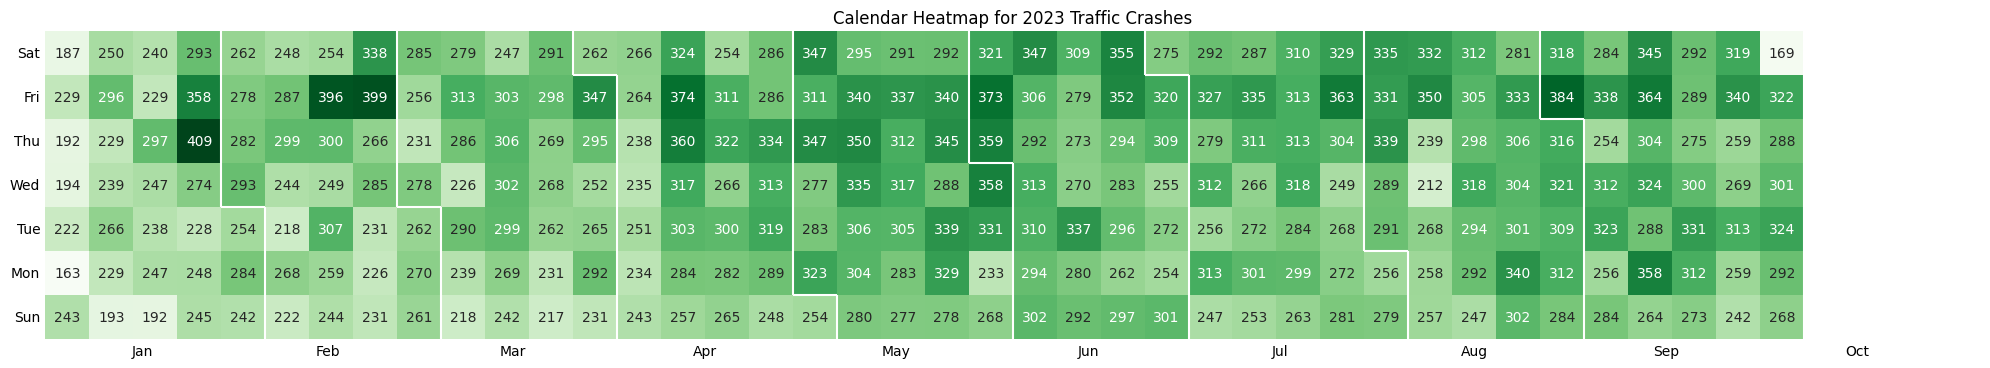

In [ ]:
create_calendar_heatmap(2023)

We are able to see that Jan 26th holds the record for the most crashes in a day with 409. Additionally, it seems like May has the most crashes overall.

### Stacked Area Chart

We've modified the original sketch for this chart to better represent the dataset's true values. This allows us to see how injury levels have evolved over time. We've extended the range of the dataset for more differentiation and insights into the entirety of the dataset.

This provides a comparison into the `most_severe_injury` of crashes throughout the lifetime of the dataset using `crash_date`.

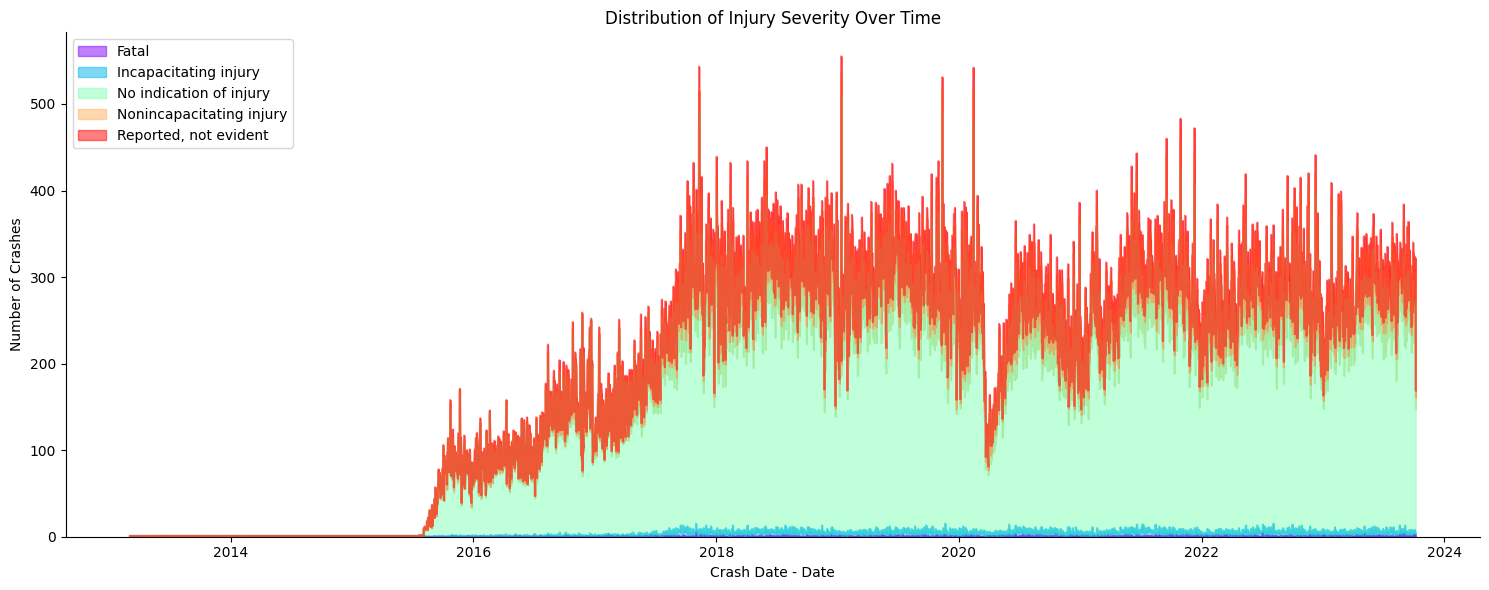

In [ ]:
daily_crash_severity = pd.crosstab(df['crash_date'].dt.date, df['most_severe_injury'])

ax = daily_crash_severity.plot(kind='area', stacked=True, alpha=0.5, figsize=(15,6), colormap='rainbow')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('Distribution of Injury Severity Over Time')
plt.ylabel('Number of Crashes')
plt.xlabel('Crash Date - Date')

# we're doing this otherwise the colors don't match
handles, labels = ax.get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
plt.legend(handles, labels, loc='upper left')


plt.tight_layout()
plt.show()

We can observe peaks in crashes in 2018, 2019, and 2020, along with the dip during COVID-19. There seems to be no indication of or non evident injuries for the most part.

The data for earlier years may be incorrect with possible missing car crashes. This is possibly due to the amount of incomplete data removed during our cleaning.

### Double-Time Bar Graph

This is another temporal visualization offering insights into the `crash_time`. We've split the hours into two categories: day and night, with hours ranging from 6AM to 5PM and 6PM to 5AM.

We've modified this bar to reflect the corresponding hours over the x-axis for better comparison into how the crashes differ during these timeframes. Furthermore, we added the number of crashes to each bar for better visibility.

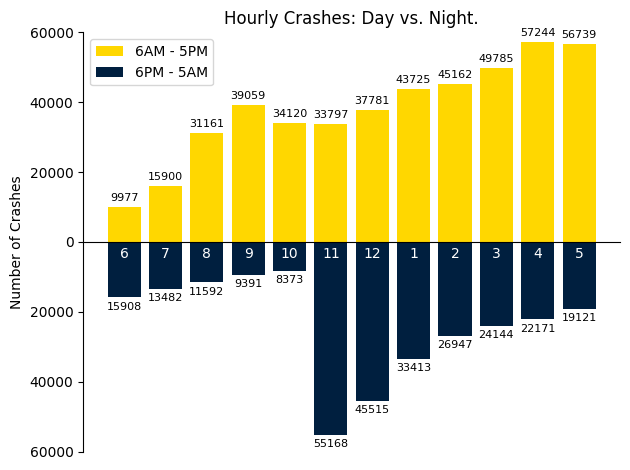

In [ ]:
crash_hour = df.groupby('crash_hour').size().values

day_counts = day_counts = crash_hour[5:17] # 6AM - 5PM
night_counts = np.concatenate((-crash_hour[:5], -crash_hour[17:])) # 6PM - 5AM

max_value = max(day_counts.max(), abs((night_counts).min()))

plt.ylim(-max_value, max_value)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position('center')

positions = list(range(0, 12))

day_bar = plt.bar(positions, day_counts, color='#FFD700', label='6AM - 5PM')
night_bar = plt.bar(positions, night_counts, color='#001F3F', label='6PM - 5AM')

# add a visual for the count
plt.bar_label(day_bar, padding=3, fontsize=8)
plt.bar_label(night_bar, labels=-night_counts, padding=3, fontsize=8)

# modify the y-ticks to show positive numbers on both sides of the x-axis
y_ticks_values = ax.get_yticks()
ax.set_yticks(y_ticks_values) # setting it back to itself to remove warning
y_labels = [int(abs(val)) for val in y_ticks_values]
ax.set_yticklabels(y_labels)

ax.tick_params(axis="x", which="both", length=0, colors='white') # remove the ticks

x_locations = list(range(0, 12))

x_labels = list(range(6, 13)) + list(range(1, 6))

plt.xticks(x_locations, x_labels)

plt.title('Hourly Crashes: Day vs. Night.')
plt.ylabel('Number of Crashes')

plt.legend()

plt.tight_layout()
plt.show()

Based on this graph, we can observe the higher number of crashes throughout the daytime compared to the nighttime. Furthermore, there is a clear indication of high crash frequencies near or at midnight.

### Grouped Bar Graphs

We've modified the grouped bar chart to incorporating the number of different injuries at crashes to better represent important aspects of the dataset. To expand our domain question into other areas of the dataset, we're looking at how variations in lighting, weather, roadway surface, and road defects influence the aftermaths of crashes as opposed to the likelihood of them occuring.

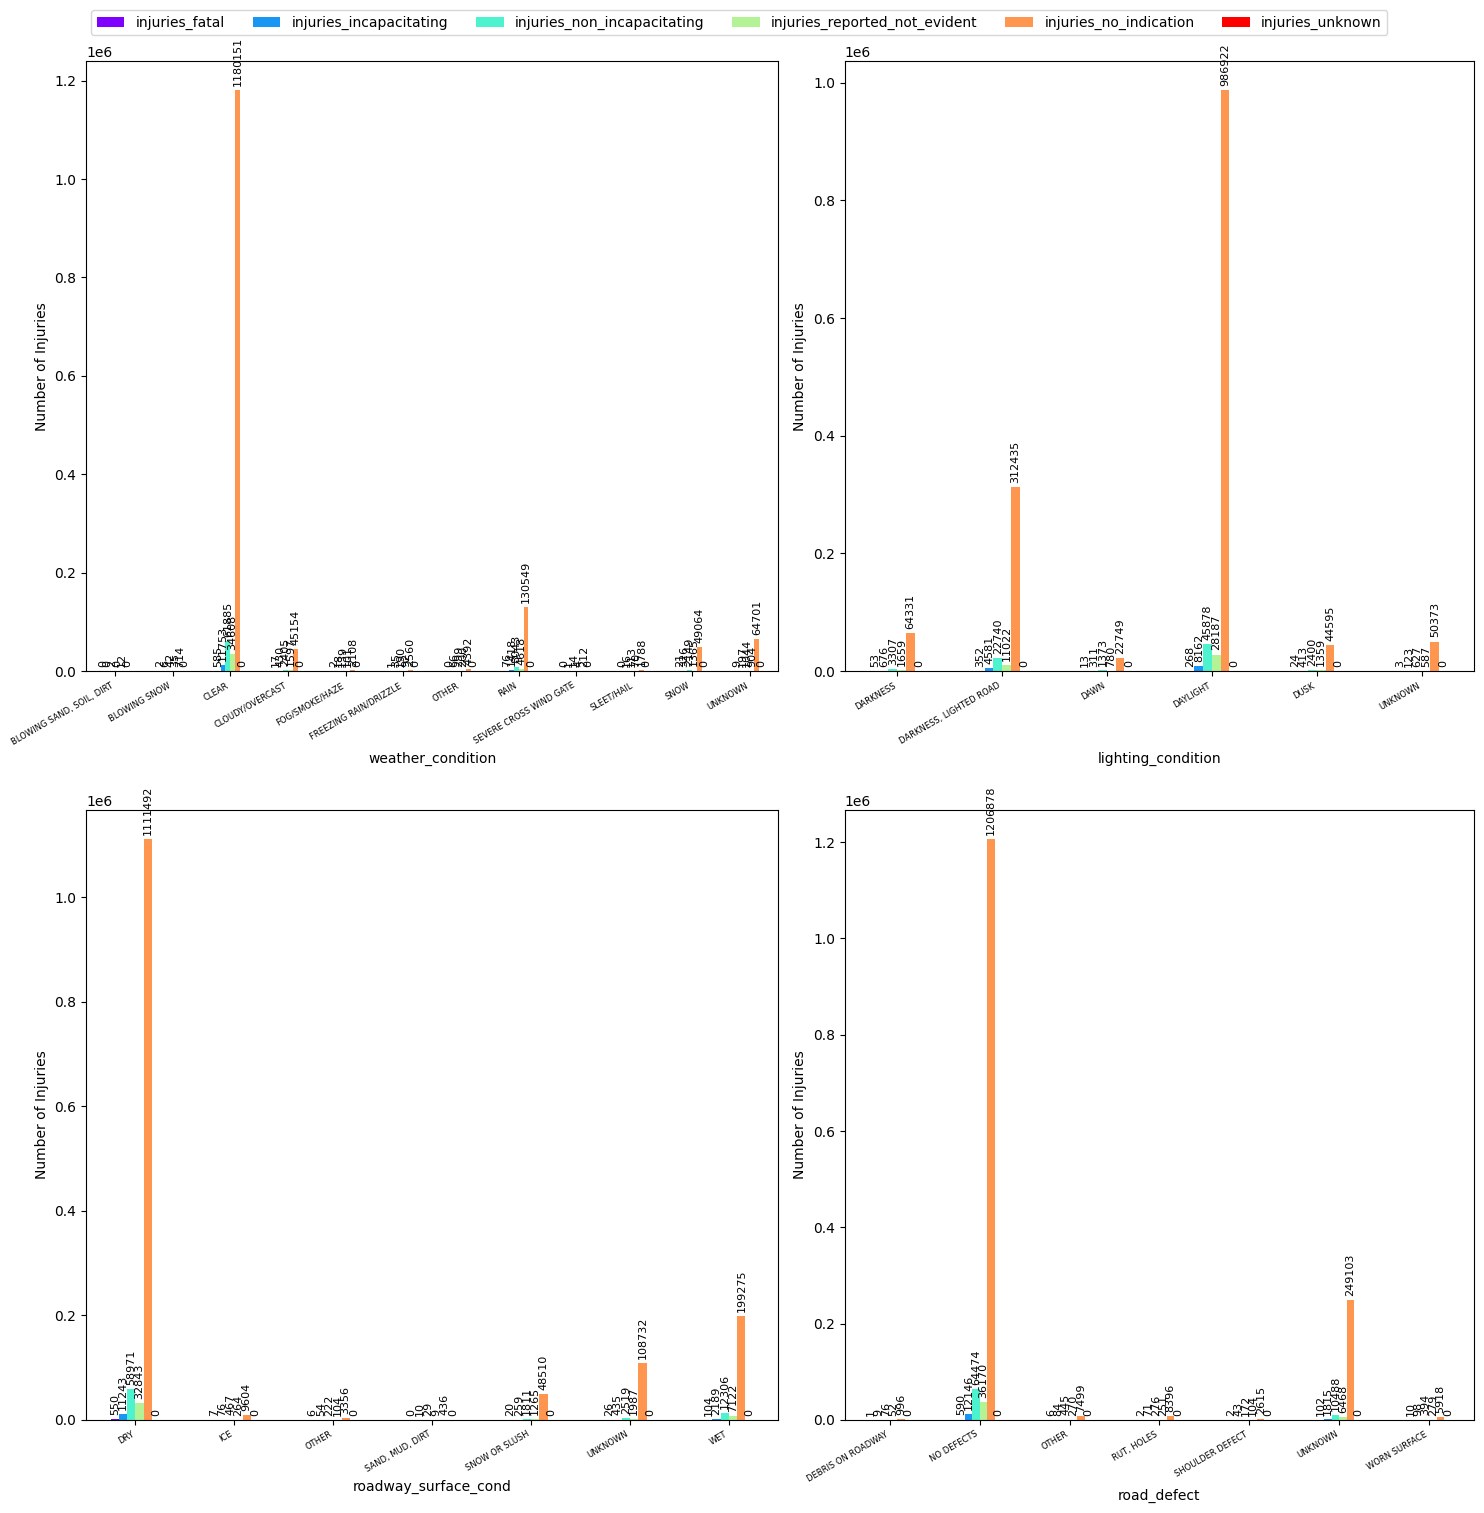

In [ ]:
injury_types = ['injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown']

fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'width_ratios': [1.1,1]})
axs = axs.ravel()

columns = ['weather_condition', 'lighting_condition', 'roadway_surface_cond', 'road_defect']

# Create a separate graph for each condition
for i, column in enumerate(columns):
    ax = axs[i]

    data = df.groupby(column)[injury_types].sum()
    data.plot(kind='bar', ax=ax, colormap='rainbow')

    handles, labels = ax.get_legend_handles_labels()

    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

    ax.set_ylabel('Number of Injuries')

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3, rotation=90, fontsize=8, label_type='edge')

    ax.legend().remove()

fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.01))

plt.tight_layout()
plt.show()

We are able to observe that most injuries occur in normal conditions, such as dry road sufaces, no defects, clear weather, and in the daylight. However, there are high likelihoods for crashes to occur during the night and during the rain. The relationship between `weather_condition` and `roadway_surface_cond` is highlighted through the similarities in the spikes in the bars.

We'll use a beat boundaries map as a backdrop for the spatial visualizations.

In [ ]:
boundaries_gdf = gpd.read_file(beat_boundaries)

### Choropleth Map

We're utilizing the available spatial data (`geometry` or `location`) from the dataset to identify hotspots within the city by looking at the frequency of crashes at each location. This directly answers our question: "Utilizing the available locational data, can we identify specific hotspots within the city where crashes are more frequent?"

However, we've decided to expand this by adding a temporal element to show these crashes based on the `crash_hour`.

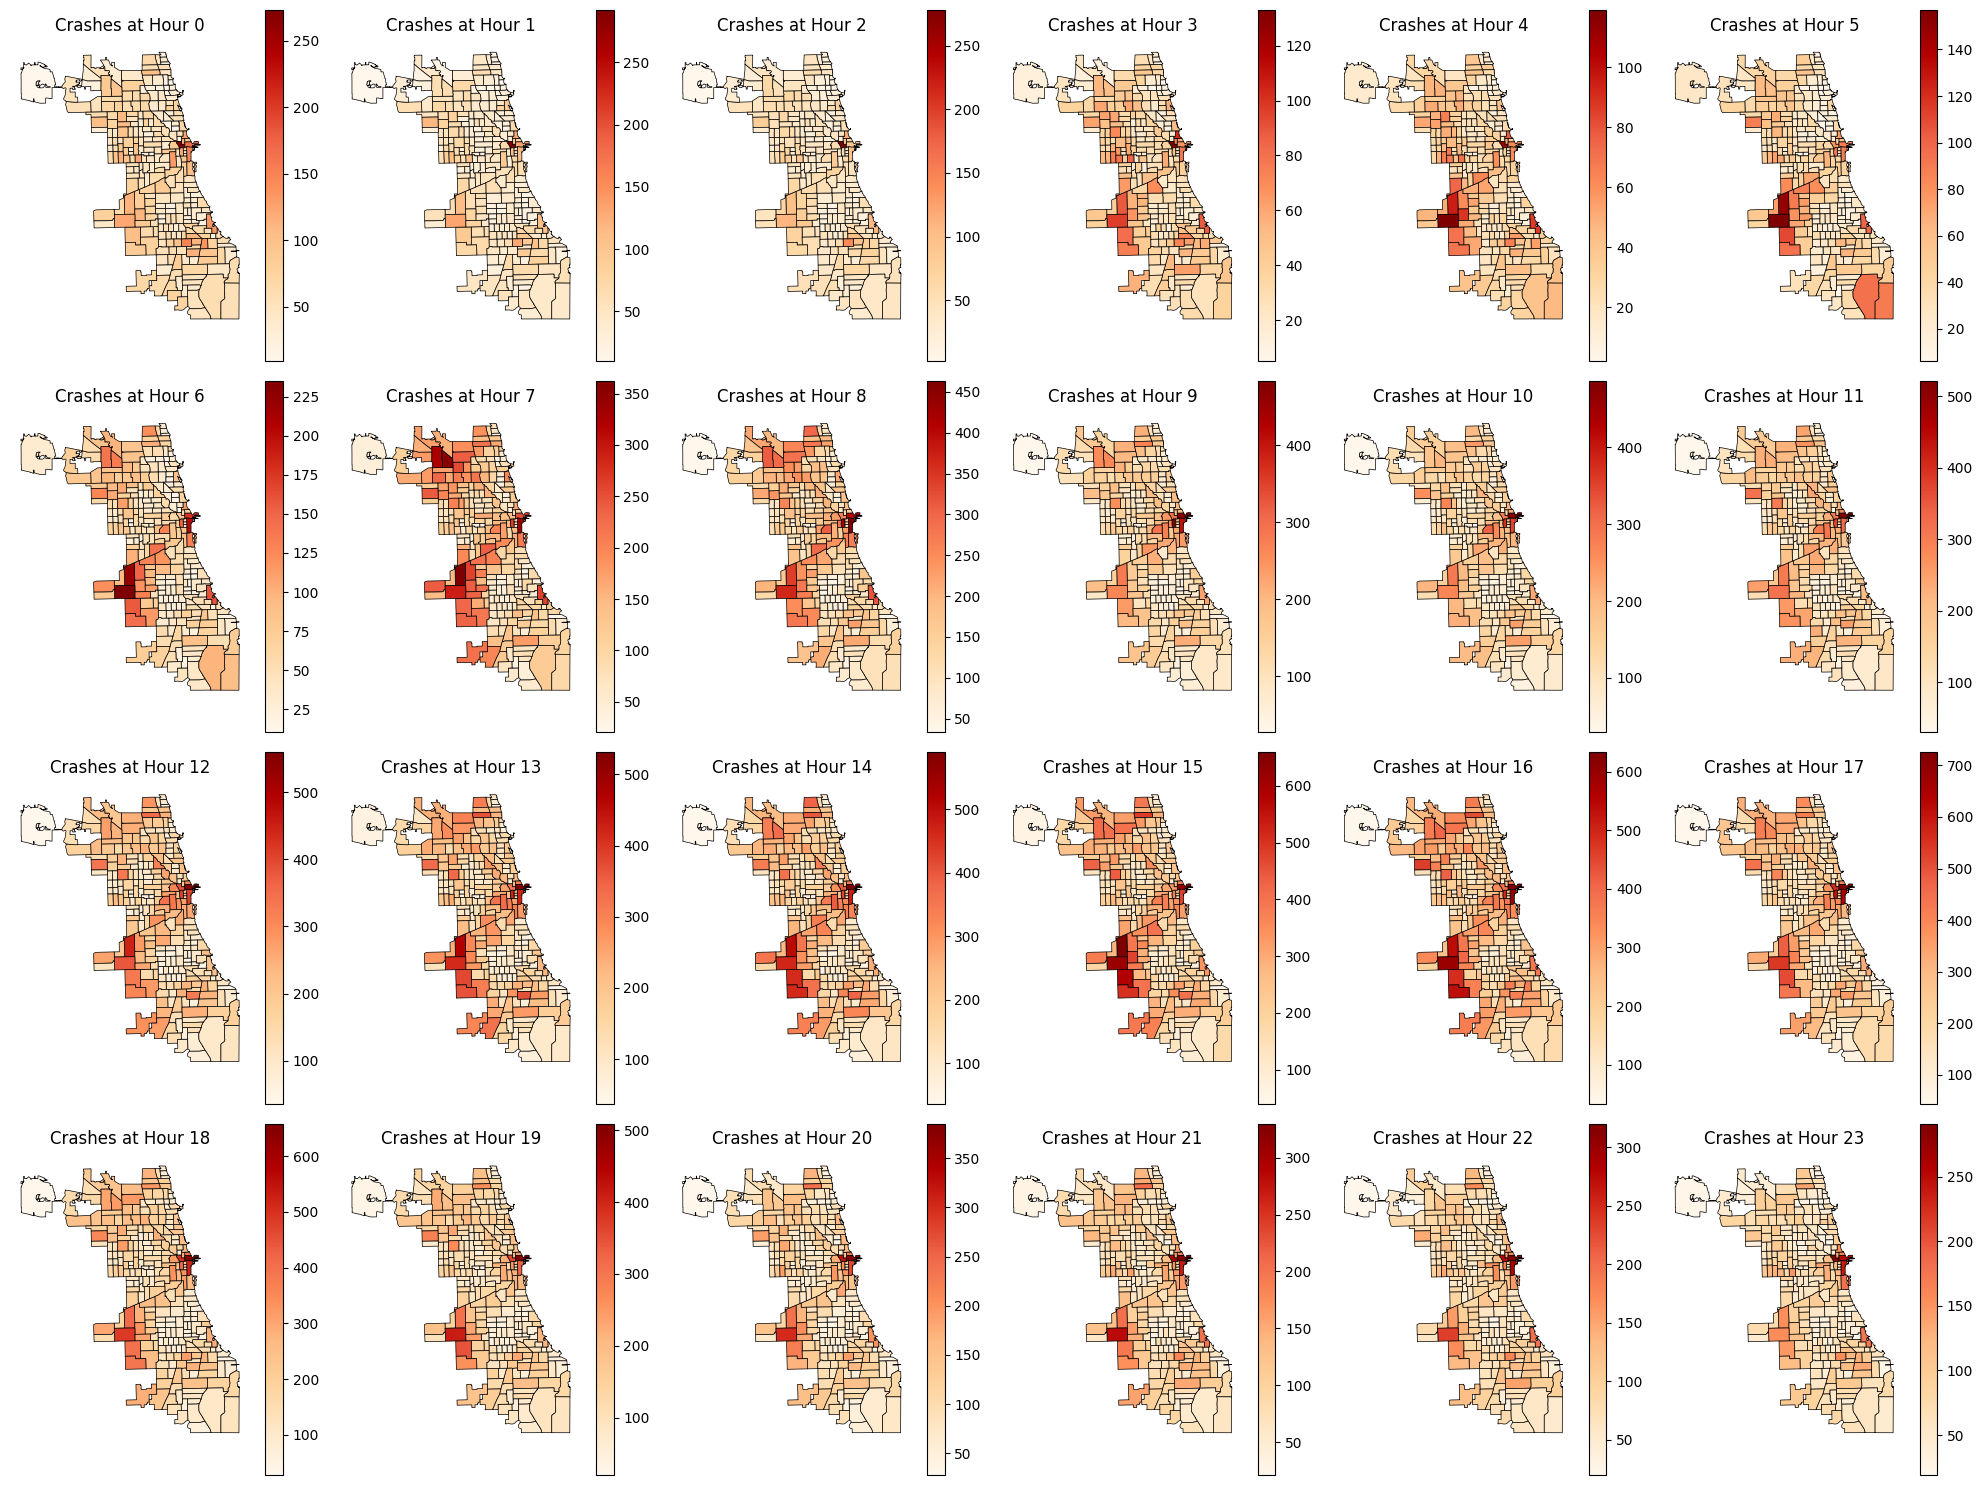

In [ ]:
crashes_per_beat = gdf.groupby(['beat_of_occurrence', 'crash_hour']).size().reset_index(name='num_crashes')

boundaries_gdf['beat_num'] = boundaries_gdf['beat_num'].astype(int) # Quick fix to modify the type for merging

# Combine the two GeoDataFrames based on the police beat.
merged_gdf = boundaries_gdf.merge(crashes_per_beat, left_on='beat_num', right_on='beat_of_occurrence', how='left')

merged_gdf['num_crashes'].fillna(0, inplace=True)

unique_hours = sorted(crashes_per_beat['crash_hour'].unique())

fig, axs = plt.subplots(4, 6, figsize=(20, 15)) # Create a subplot for each hour

# Generate a choropleth map for each hour.
for ax, hour in zip(axs.ravel(), unique_hours):
    subset = merged_gdf[merged_gdf['crash_hour'] == hour]
    subset.plot(column='num_crashes', ax=ax, legend=True, cmap='OrRd', edgecolor='k', linewidth=0.5)
    ax.set_title(f'Crashes at Hour {int(hour)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Based on this set of graphs, we can see the high frequency of crashes towards the middle-bottom-left and middle-right. These are beats with high amounts of traffic, encompassing areas such as the Loop and West Lawn. Similar to our discovery from the Double-Time Bar Graph, it seems that most crashes occur during the day.

### Geospatial Heatmap

This corresponds the our first sketch pertaining to the question mentioned for our Choropleths. However, we are correcting the incorrect use of colored points from our first sketch. This solely looks at the `geometry` column for the coordinates of each crash.

Please note that this step will take a while due to the calculations performed for the kernel density estimates.

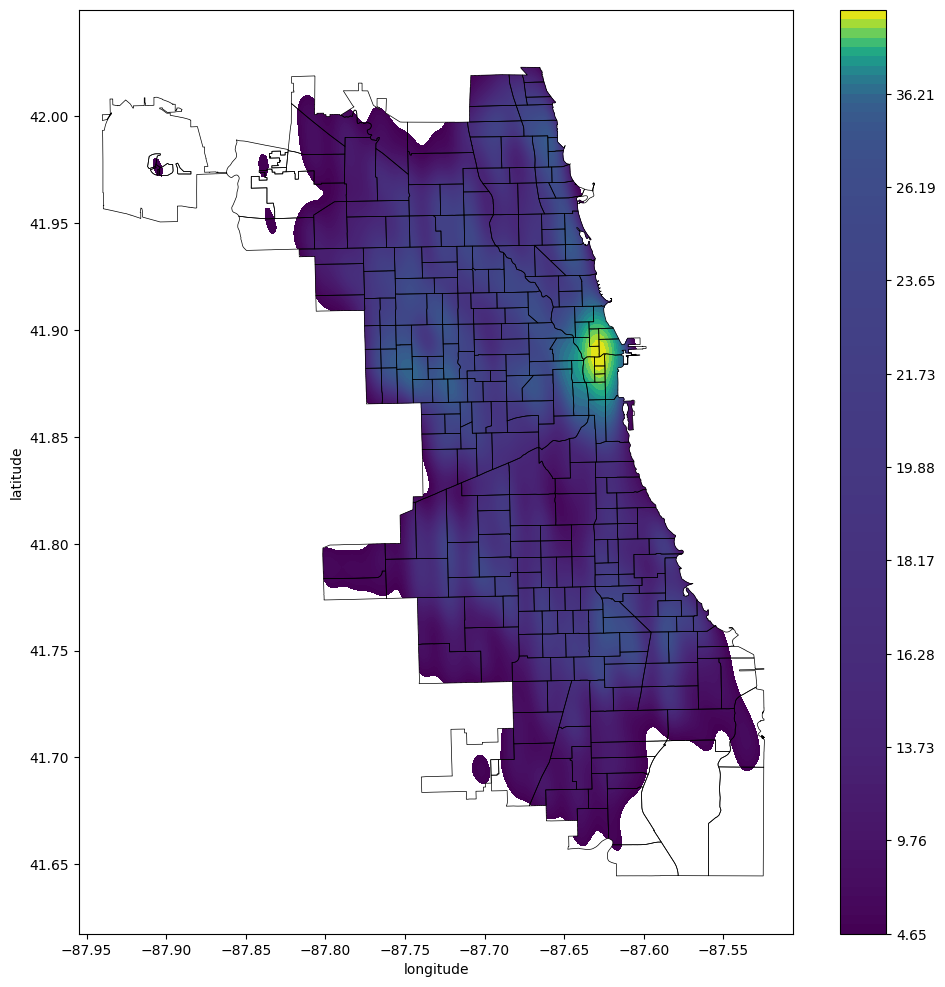

In [ ]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# We're taking the actual boundary from the boundary
multipolygon = boundaries_gdf.unary_union
path = Path(multipolygon.exterior.coords)

# Creation of the Heatmap
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(x=gdf.longitude, y=gdf.latitude, ax=ax, cmap='viridis', cbar=True, fill=True, levels=100)
ax.set_aspect('equal')

# This will ensure that the shape of our heatmap stays on the actual map
path_patch = PathPatch(path, facecolor='none', edgecolor='none')
ax.add_patch(path_patch)

for collection in ax.collections:
    collection.set_clip_path(path_patch)

# Add the file containing the boundaries
boundaries_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

plt.show()

This finds that most crashes occur towards Downtown near areas like The Loop similar to our previous findings in the choropleths.

### Heatmap

This pertains to our fourth domain question on the correlation between `PRIM_COUNTRIBUTORY_CAUSE` and `SEC_COUNTRIBUTORY_CAUSE`.

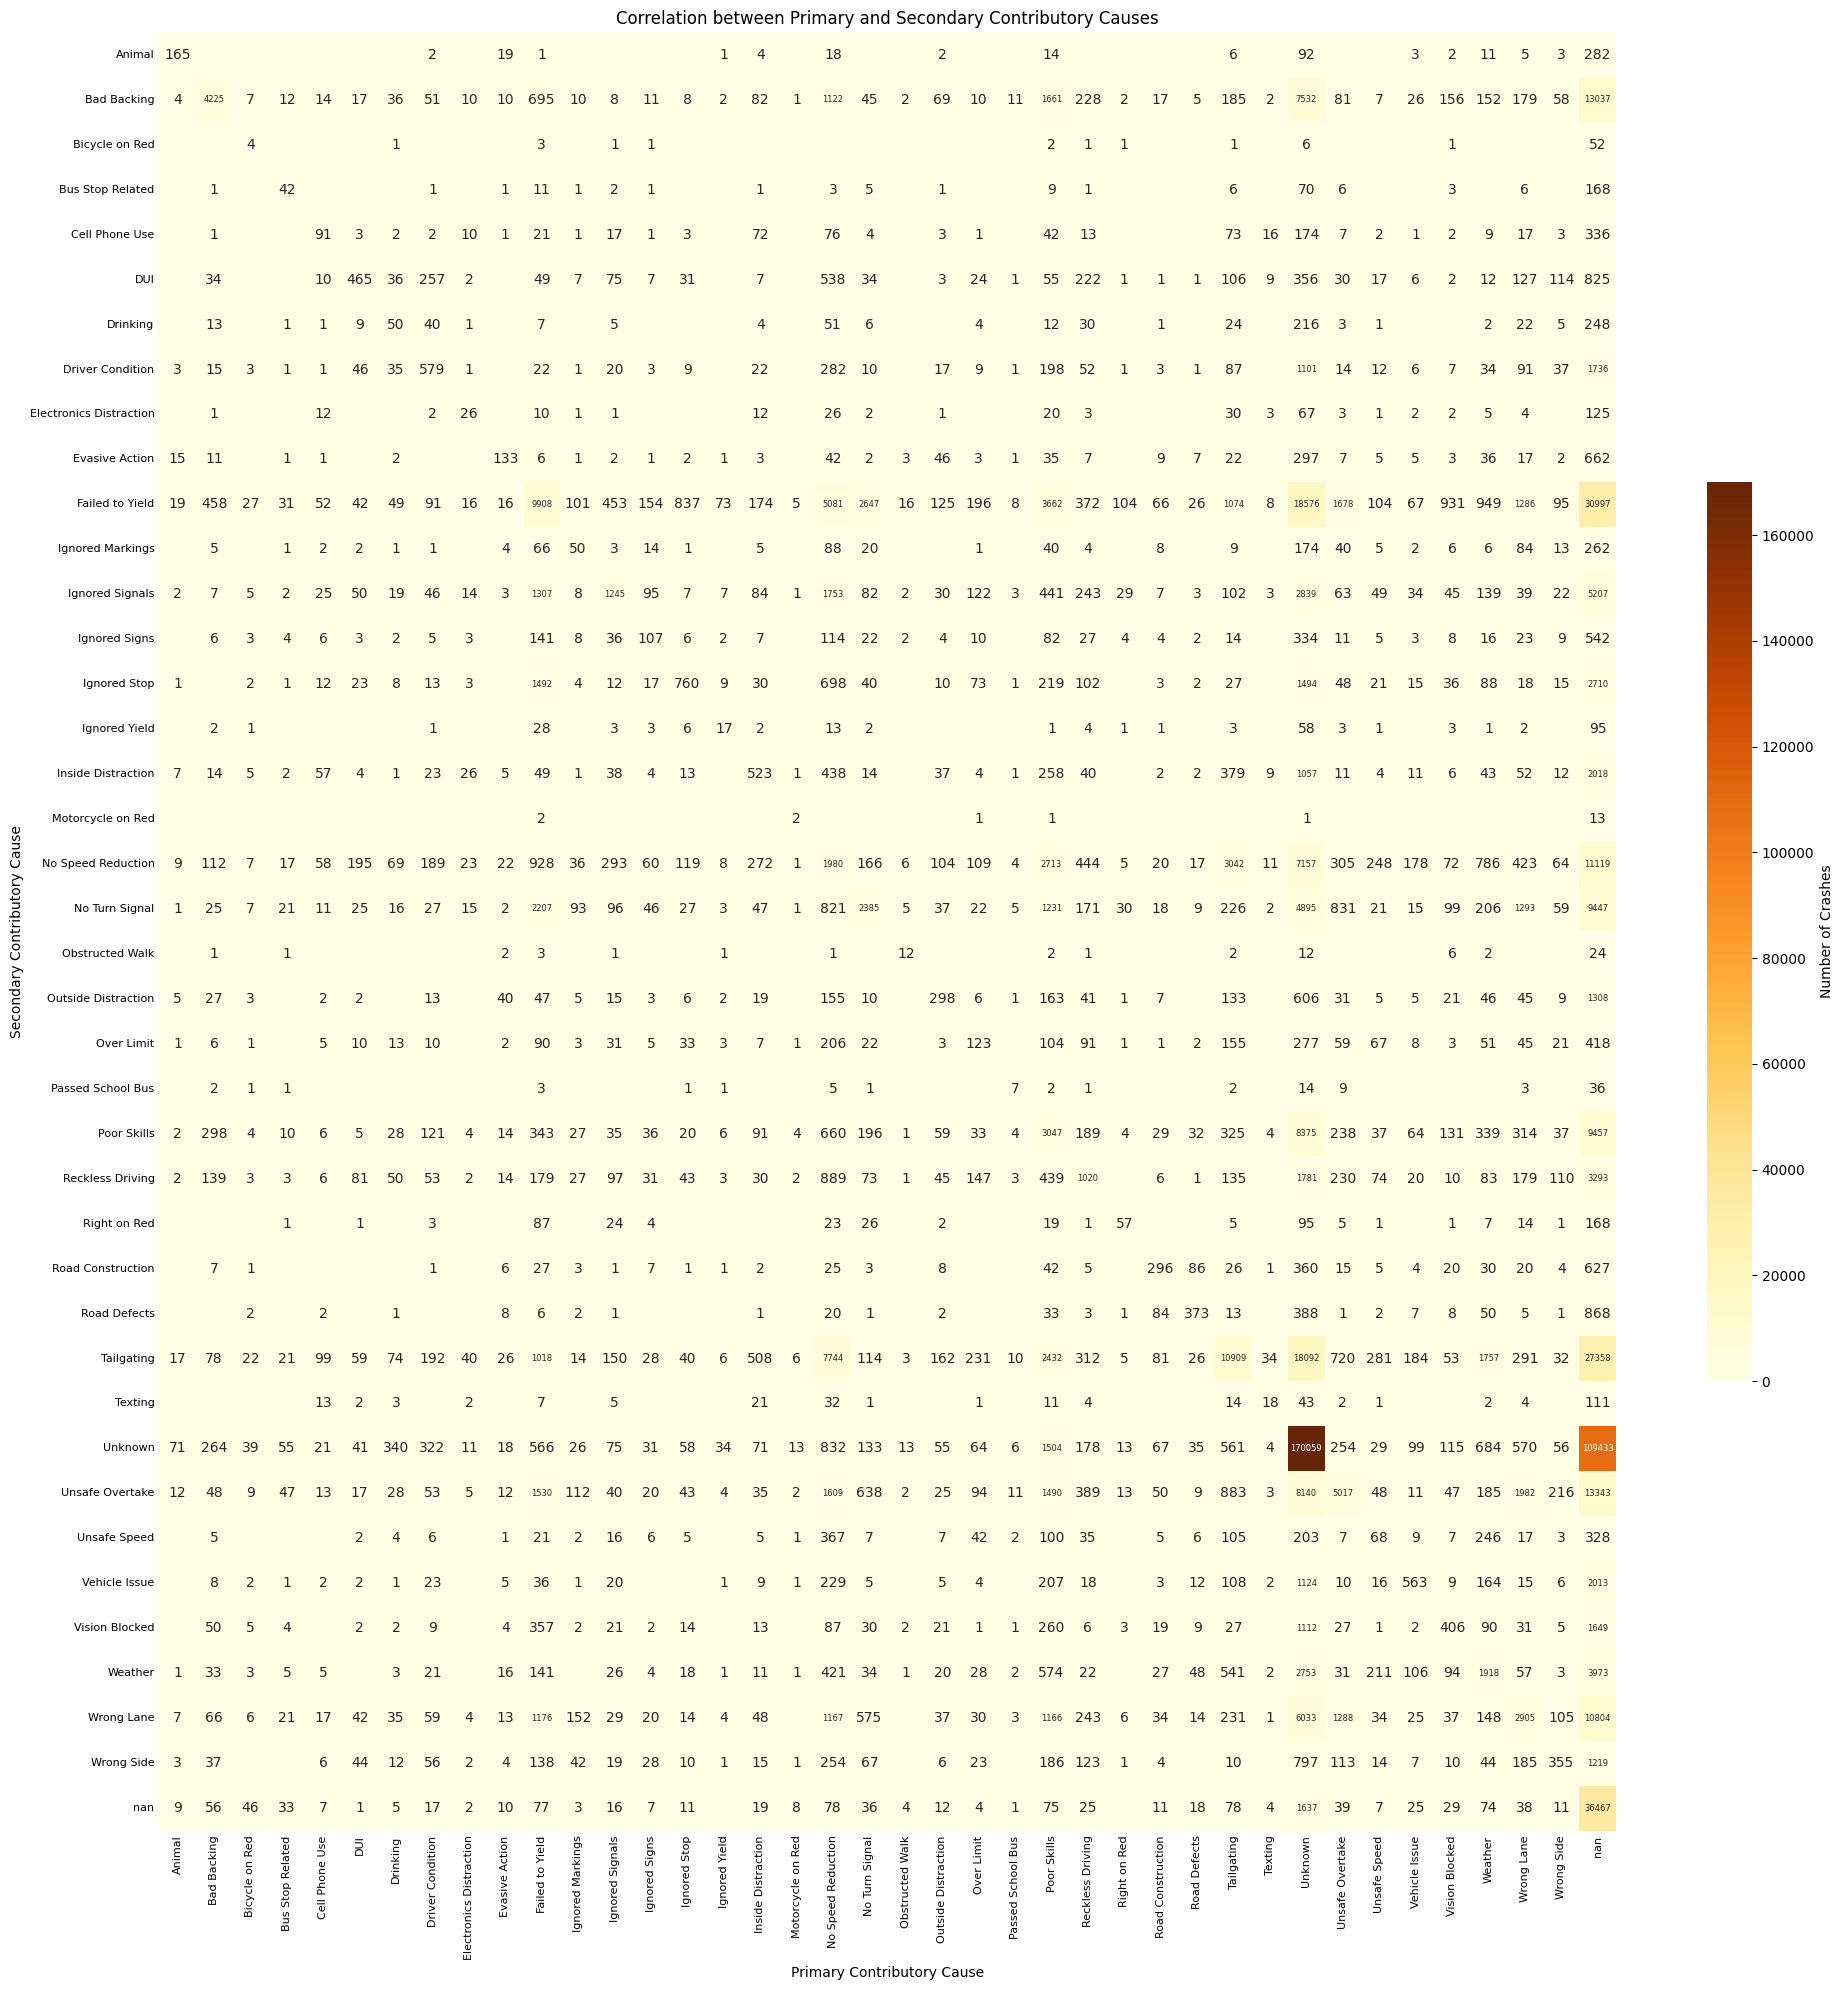

In [ ]:
def determine_text_size(value):
    return 6 if len(str(value)) > 3 else 10

cause_pivot = pd.crosstab(df['prim_contributory_cause'], df['sec_contributory_cause'])

annotations = [[str(val) if val > 0 else '' for val in row] for row in cause_pivot.values]
text_sizes = [[determine_text_size(val) for val in row] for row in cause_pivot.values]

plt.figure(figsize=(20, 20))
ax = sns.heatmap(cause_pivot, cmap='YlOrBr', annot=annotations, fmt='', cbar_kws={'label': 'Number of Crashes', 'shrink': 0.5})

for text, size in zip(ax.texts, (size for row in text_sizes for size in row)):
    text.set_size(size)

plt.title('Correlation between Primary and Secondary Contributory Causes')
plt.xlabel('Primary Contributory Cause')
plt.ylabel('Secondary Contributory Cause')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

ax.tick_params(axis="both", which="both", length=0) # remove the ticks

plt.tight_layout()

plt.show()

Based on this heatmap, it seems that most of the data for the causes are unknown and hence skews the dataset.